# First Test for Volatility Based VaR

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from itertools import product

# Import functions
import VolatilityVaR
import Backtesting
import InteractivePlots
import ExpectedShortfall as ES

### Data

In [21]:
# Download data
sp500_data = yf.download("^GSPC", start="2017-01-01", end="2021-01-01")
sp500_data["Log Returns"] = np.log(sp500_data["Close"] / sp500_data["Close"].shift(1))
returns = sp500_data["Log Returns"].dropna()

[*********************100%***********************]  1 of 1 completed


### Garch based VaR on S&P 500

In [22]:
# Set parameters
confidence_level = 0.99 # <----- Can choose 0.95 etc

In [23]:
# Apply GARCH volatility model
garch_output, next_day_var = VolatilityVaR.var_garch(returns, confidence_level, vol_model="GJR")

print(f"Next-day GARCH VaR estimate (abs): {100 * next_day_var:.2f}%")

# Backtest full period
violations, rate = Backtesting.backtest_var(garch_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Backtest a subset
viol_subset, rate_subset = Backtesting.backtest_var(garch_output, confidence_level, "2019-11-01", "2020-11-30")
print(f"Subset — Violations: {viol_subset}, Rate: {rate_subset:.2f}%")

# Compute ES for the whole period
garch_output = ES.compute_expected_shortfall_volatility(garch_output, confidence_level)

# Plot interactive VaR
fig_var = InteractivePlots.interactive_plot_var(garch_output)
fig_var.show()

# Plot interactive ES for a subset
fig_es = InteractivePlots.interactive_plot_es(garch_output, subset=("2019-11-01", "2020-11-30"))
fig_es.show()

# Plot interactive volatility for a subset
fig_vol = InteractivePlots.interactive_plot_volatility(garch_output["Volatility"], subset=("2019-11-01", "2020-11-30"))
fig_vol.show()


Next-day GARCH VaR estimate (abs): 1.45%
Full Period — Violations: 11, Rate: 1.09%
Subset — Violations: 4, Rate: 1.47%


In [24]:
print(next_day_var)

0.014522369237990235


In [25]:
garch_output.head()

,Returns,Volatility,Innovations,VaR,VaR Violation,ES
Date,,,,,,
2017-01-04,0.005706,0.004050,1.408826,0.011728,False,0.016039
2017-01-05,-0.000771,0.004304,-0.179122,0.012463,False,0.017045
2017-01-06,0.003511,0.004182,0.839481,0.012110,False,0.016561
2017-01-09,-0.003555,0.004104,-0.866126,0.011885,False,0.016254
2017-01-10,0.000000,0.004775,0.000000,0.013826,False,0.018908


### Garch Forecasts

In [26]:
# Configuration grid
steps_list = [1, 5, 10]
cumulative_list = [False, True]
distributions = ["normal", "t", "ged"]

print("GARCH(1,1) VaR Forecasts\n" + "-" * 30)

for steps_ahead, cumulative, dist in product(steps_list, cumulative_list, distributions):
    try:
        var_value = VolatilityVaR.garch_forecast(
            returns=returns,
            steps_ahead=steps_ahead,
            cumulative=cumulative,
            compute_var=True,
            confidence_level=0.99,
            distribution=dist
        )

        label = f"VaR | {steps_ahead}-day | {'CUM' if cumulative else 'Single'} | {dist.upper()}"
        print(f"{label:<45}: {var_value * 100:.4f}%")  # Multiply decimal VaR by 100

    except Exception as e:
        print(f"{label:<45}: ERROR → {e}")

# Variances (print volatility in percentage)
print("\nGARCH(1,1) Variance Forecasts")
print("-------------------------------")

for horizon in [1, 5, 10]:
    for cumulative in [False, True]:
        var_type = "CUM" if cumulative else "Single"
        variance = VolatilityVaR.garch_forecast(
            returns,
            steps_ahead=horizon,
            cumulative=cumulative,
            compute_var=False
        )
        std_dev = np.sqrt(variance)
        print(f"STD | {horizon}-day | {var_type:6} | {std_dev * 100:.4f}%")  # Already in correct scale

GARCH(1,1) VaR Forecasts
------------------------------
VaR | 1-day | Single | NORMAL                : 1.3652%
VaR | 1-day | Single | T                     : 1.5218%
VaR | 1-day | Single | GED                   : 1.5279%
VaR | 1-day | CUM | NORMAL                   : 1.3098%
VaR | 1-day | CUM | T                        : 1.4601%
VaR | 1-day | CUM | GED                      : 1.4660%
VaR | 5-day | Single | NORMAL                : 1.5578%
VaR | 5-day | Single | T                     : 1.7365%
VaR | 5-day | Single | GED                   : 1.7435%
VaR | 5-day | CUM | NORMAL                   : 3.1669%
VaR | 5-day | CUM | T                        : 3.5302%
VaR | 5-day | CUM | GED                      : 3.5445%
VaR | 10-day | Single | NORMAL               : 1.7520%
VaR | 10-day | Single | T                    : 1.9530%
VaR | 10-day | Single | GED                  : 1.9609%
VaR | 10-day | CUM | NORMAL                  : 4.8450%
VaR | 10-day | CUM | T                       : 5.4009%
VaR | 10-

### MA based VaR on the same data

In [27]:
# Apply MA volatility model
ma_output, next_day_var = VolatilityVaR.var_moving_average(returns, confidence_level)

print(f"Next-day MA VaR estimate (abs): {100 * next_day_var:.2f}%")

# Backtest full period
violations, rate = Backtesting.backtest_var(ma_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Backtest a subset
viol_subset, rate_subset = Backtesting.backtest_var(ma_output, confidence_level, "2019-11-01", "2020-11-30")
print(f"Subset — Violations: {viol_subset}, Rate: {rate_subset:.2f}%")

# Compute ES for the whole period
ma_output = ES.compute_expected_shortfall_volatility(ma_output, confidence_level)

# Plot interactive VaR
fig_var = InteractivePlots.interactive_plot_var(ma_output)
fig_var.show()

# Plot interactive ES for a subset
fig_es = InteractivePlots.interactive_plot_es(ma_output, subset=("2019-11-01", "2020-11-30"))
fig_es.show()

# Plot interactive volatility for a subset
fig_vol = InteractivePlots.interactive_plot_volatility(ma_output["Volatility"], subset=("2019-11-01", "2020-11-30"))
fig_vol.show()


Next-day MA VaR estimate (abs): 1.48%
Full Period — Violations: 10, Rate: 1.01%
Subset — Violations: 4, Rate: 1.47%


### Test New Caller Function (static images)


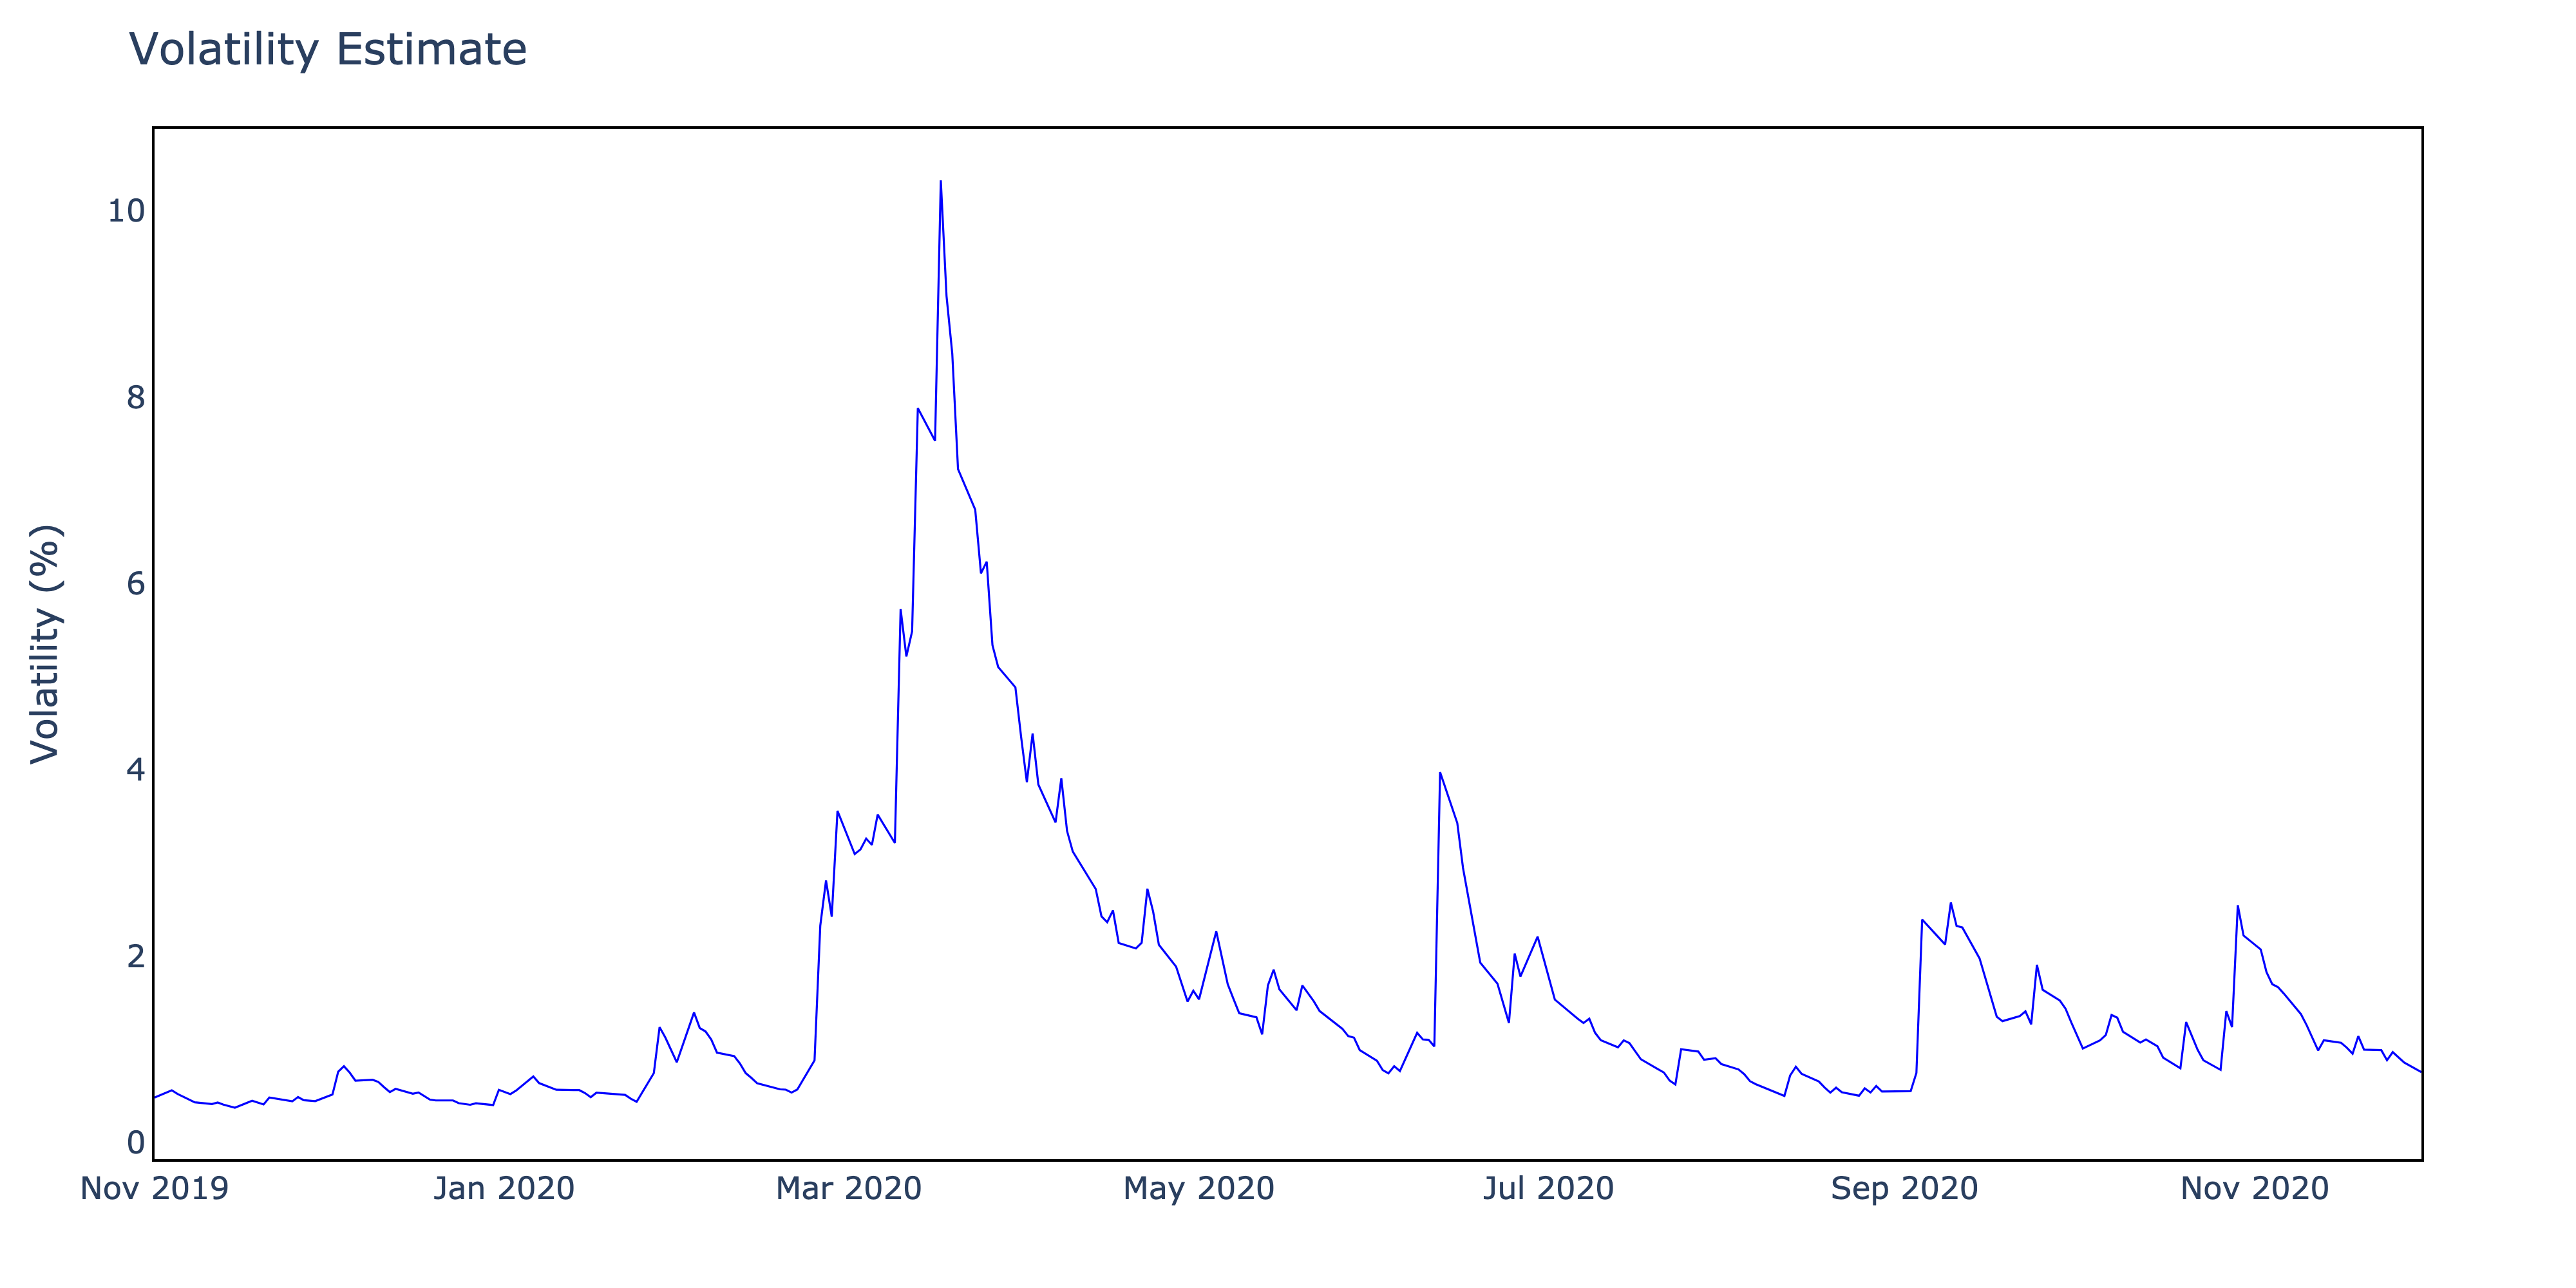

In [28]:
InteractivePlots.plot_caller(
    plot_type="volatility",
    interactive=False,
    volatility_series=garch_output["Volatility"],
    subset=("2019-11-01", "2020-11-30")
)



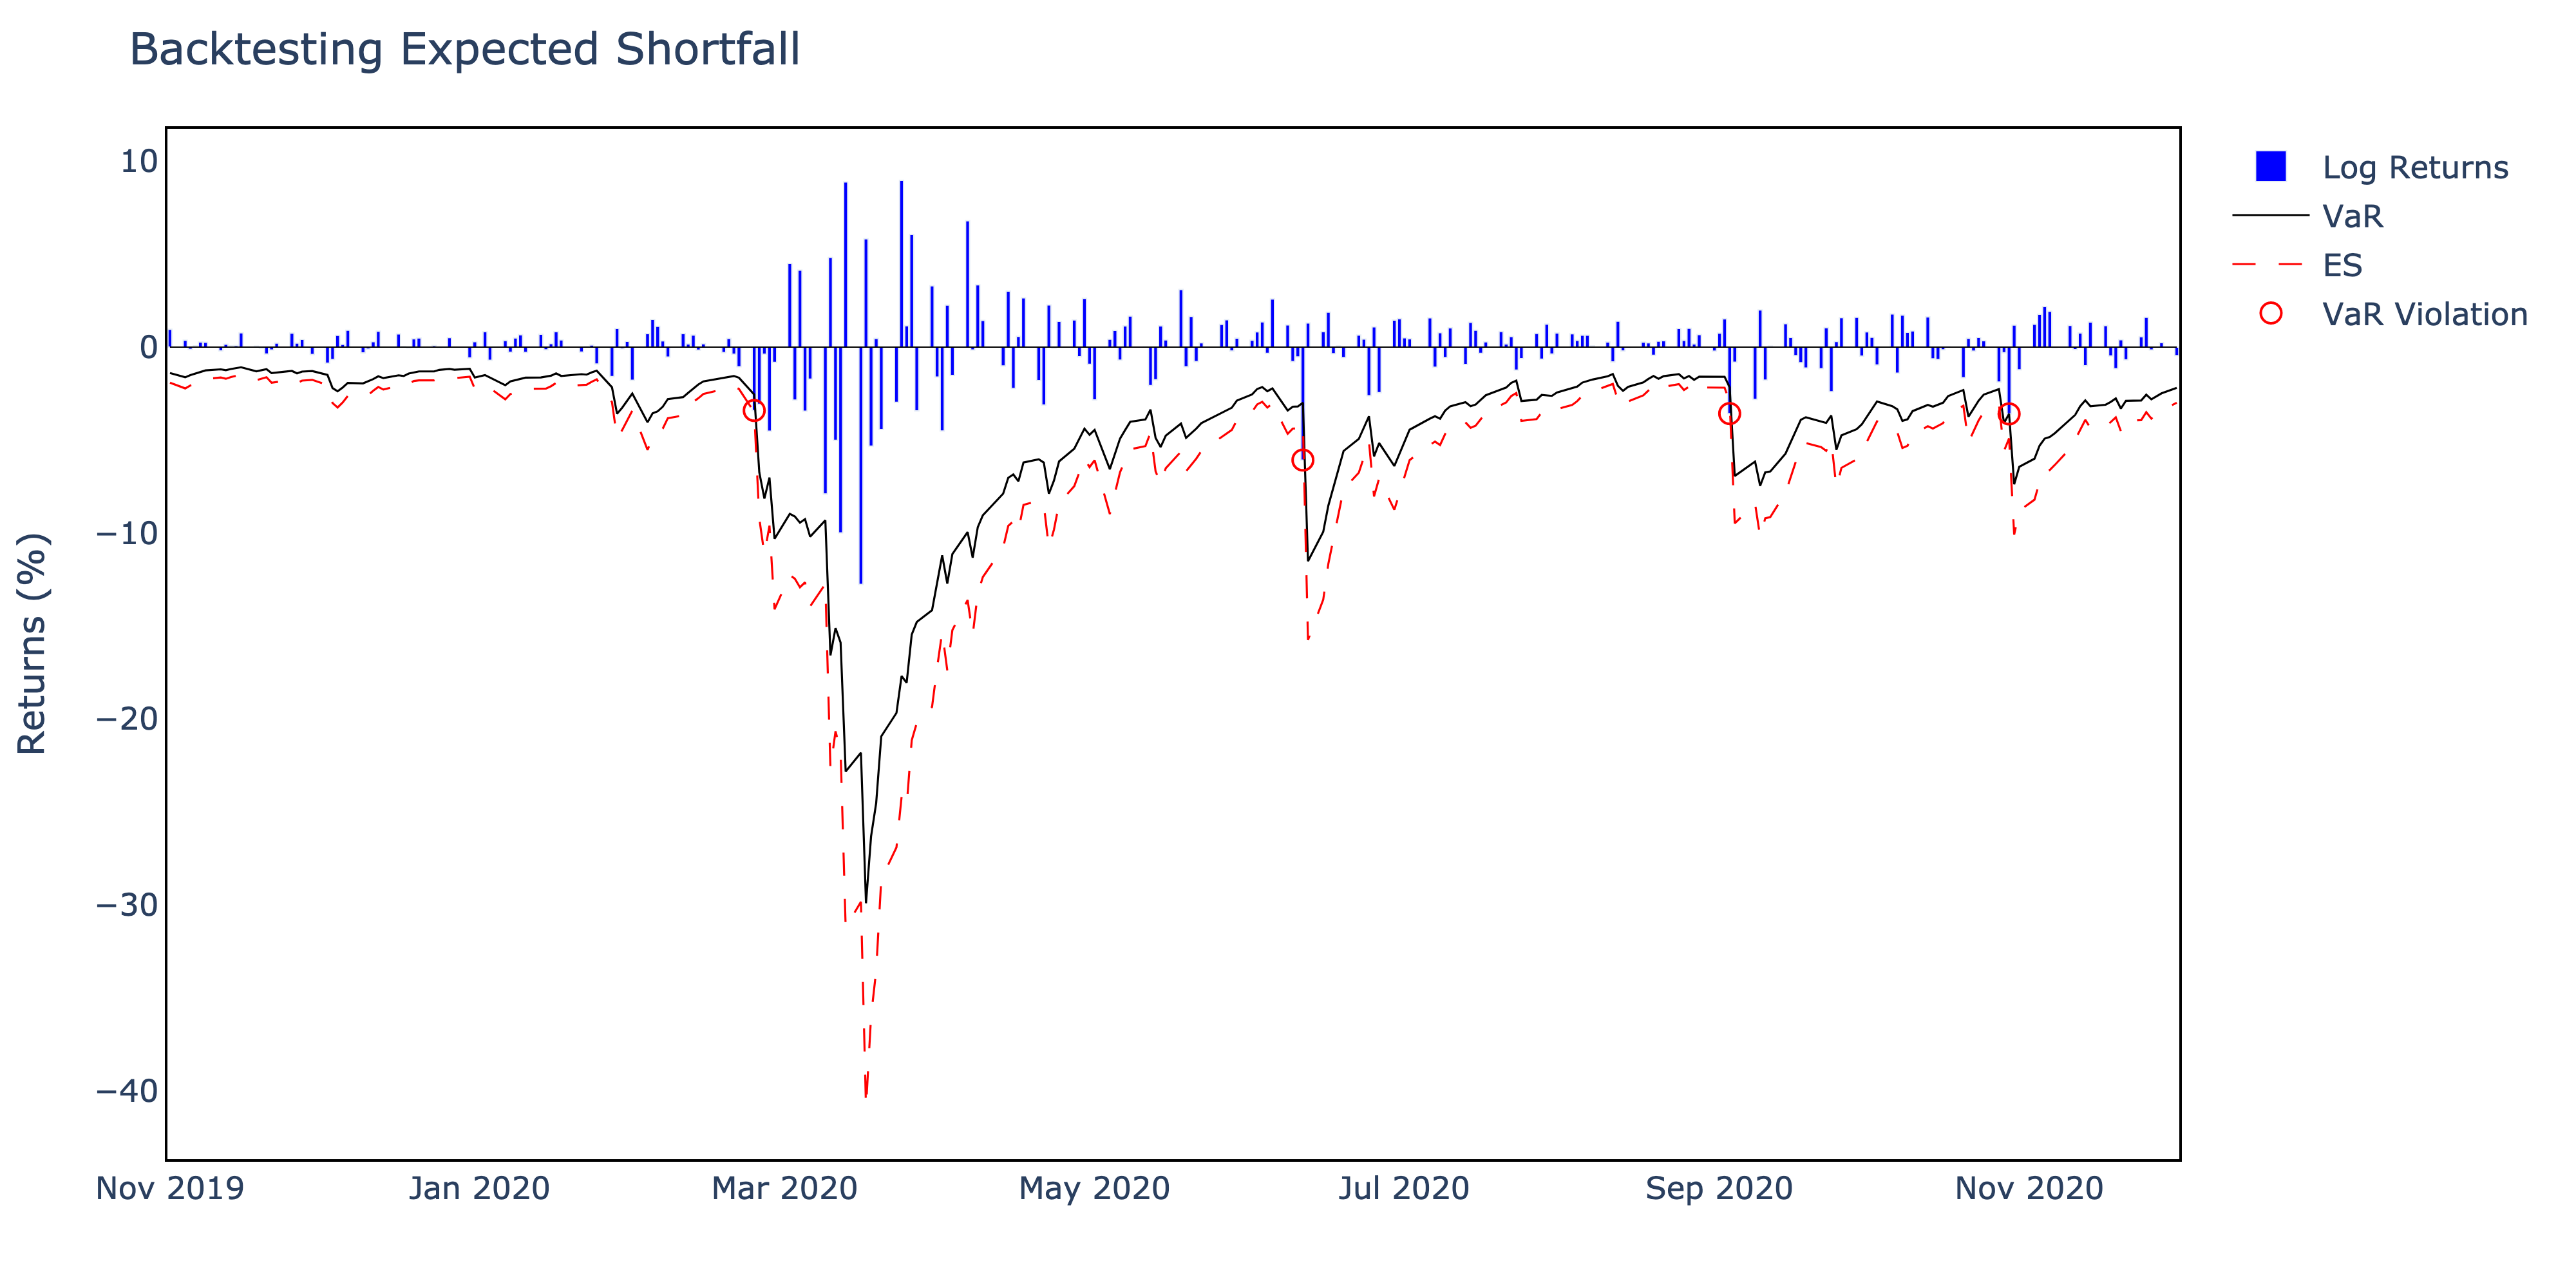

In [29]:
InteractivePlots.plot_caller(
    plot_type="backtest_es",
    interactive=False,
    data=garch_output,
    subset=("2019-11-01", "2020-11-30")
)


### Test Caller Function for Volatility VaR

In [30]:
garch_output, next_day_var = VolatilityVaR.compute_var_volatility(returns, confidence_level, method="garch", vol_model="GJR")
print(f"Next-day GARCH VaR estimate (abs): {100 * next_day_var:.2f}%")

Next-day GARCH VaR estimate (abs): 1.45%


In [31]:
# Apply MA volatility model
ma_output, next_day_var = VolatilityVaR.compute_var_volatility(returns, confidence_level, method="ma")

print(f"Next-day MA VaR estimate (abs): {100 * next_day_var:.2f}%")

Next-day MA VaR estimate (abs): 1.48%


### Test Caller with Monetary Amounts for VaR

In [32]:
garch_output, next_day_var = VolatilityVaR.compute_var_volatility(
    returns,
    confidence_level,
    method="garch",
    vol_model="GJR",
    wealth=1_000_000  # or any monetary amount
)

print(f"Next-day GARCH VaR estimate in $ (abs): {next_day_var:.2f}")


Next-day GARCH VaR estimate in $ (abs): 14522.37


In [33]:
garch_output.head()

,Returns,Volatility,Innovations,VaR,VaR Violation,VaR_monetary
Date,,,,,,
2017-01-04,0.005706,0.004050,1.408826,0.011728,False,11727.985199
2017-01-05,-0.000771,0.004304,-0.179122,0.012463,False,12463.486982
2017-01-06,0.003511,0.004182,0.839481,0.012110,False,12110.043662
2017-01-09,-0.003555,0.004104,-0.866126,0.011885,False,11884.988302
2017-01-10,0.000000,0.004775,0.000000,0.013826,False,13826.221280


In [34]:
ma_output, next_day_var = VolatilityVaR.compute_var_volatility(
    returns,
    confidence_level,
    method="ma",
    wealth=1_000_000  # or any monetary amount
)

print(f"Next-day GARCH VaR estimate in $ (abs): {next_day_var:.2f}")


Next-day GARCH VaR estimate in $ (abs): 14782.64


In [35]:
ma_output.head()

,Returns,Volatility,Innovations,VaR,VaR Violation,VaR_monetary
Date,,,,,,
2017-02-01,0.000298,0.003687,0.080904,0.010448,False,10447.894155
2017-02-02,0.000570,0.003477,0.163979,0.009852,False,9851.835476
2017-02-03,0.007238,0.003803,1.903573,0.010775,False,10774.519959
2017-02-06,-0.002118,0.003786,-0.559352,0.010727,False,10726.972570
2017-02-07,0.000227,0.003674,0.061736,0.010410,False,10409.507135


### Garch forecast formula via caller

In [36]:
_, forecast_var = VolatilityVaR.compute_var_volatility(
    returns,
    method="forecast",
    steps_ahead=22,
    cumulative=True,
    confidence_level=0.99,
    distribution="t",
    wealth=1_000_000
)

print(f"Forecasted 1-month cumulative VaR $: {forecast_var:,.2f}")

Forecasted 1-month cumulative VaR $: 91,775.36


In [37]:
garch_output, _ = ES.compute_expected_shortfall(
    method="volatility",
    result_data=garch_output,
    confidence_level=confidence_level,
    wealth=1_000_000
)


In [38]:
garch_output.head()

,Returns,Volatility,Innovations,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,,
2017-01-04,0.005706,0.004050,1.408826,0.011728,False,11727.985199,0.016039,16038.883523
2017-01-05,-0.000771,0.004304,-0.179122,0.012463,False,12463.486982,0.017045,17044.736380
2017-01-06,0.003511,0.004182,0.839481,0.012110,False,12110.043662,0.016561,16561.376610
2017-01-09,-0.003555,0.004104,-0.866126,0.011885,False,11884.988302,0.016254,16253.596829
2017-01-10,0.000000,0.004775,0.000000,0.013826,False,13826.221280,0.018908,18908.375899


### Appendix

#### 1. GARCH(p, q) VaR  
Standard GARCH captures volatility clustering using past squared shocks and variances.

$$
r_t = \mu + \varepsilon_t, \quad \varepsilon_t = \sigma_t z_t
$$

$$
\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 2. EGARCH(p, q) VaR  
EGARCH models log-volatility and captures asymmetry in the volatility response.

$$
\log(\sigma_t^2) = \omega + \sum_{i=1}^q \beta_i \log(\sigma_{t-i}^2) + \sum_{j=1}^p \alpha_j \left( \frac{|\varepsilon_{t-j}|}{\sigma_{t-j}} - \mathbb{E}\left[ \frac{|\varepsilon_{t-j}|}{\sigma_{t-j}} \right] \right) + \gamma_j \frac{\varepsilon_{t-j}}{\sigma_{t-j}}
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 3. GJR-GARCH(p, q) VaR  
GJR-GARCH adds an indicator term to account for the leverage effect of negative shocks.

$$
\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2 + \sum_{i=1}^q \gamma_i \varepsilon_{t-i}^2 \cdot \mathbb{I}_{\{\varepsilon_{t-i}<0\}}
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 4. APARCH(p, q) VaR  
APARCH generalizes GARCH with power terms and asymmetry.

$$
\sigma_t^\delta = \omega + \sum_{i=1}^q \alpha_i \left( |\varepsilon_{t-i}| - \gamma_i \varepsilon_{t-i} \right)^\delta + \sum_{j=1}^p \beta_j \sigma_{t-j}^\delta
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 5. ARCH(p) VaR  
ARCH models volatility using only past squared residuals.

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \varepsilon_{t-i}^2
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 6. EWMA VaR  
EWMA assigns exponentially decaying weights to past squared returns.

$$
\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_{t-1}^2
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 7. MA VaR  
Moving Average volatility is estimated using a rolling window of past squared returns.

$$
\sigma_t = \sqrt{ \frac{1}{n} \sum_{i=1}^n r_{t-i}^2 }
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 8. Expected Shortfall (ES)  
Expected Shortfall estimates the conditional expectation of loss beyond the VaR.

$$
\text{ES}_t = -\hat{\sigma}_t \cdot \mathbb{E}[z_t \mid z_t < z_\alpha]
$$

---

#### 9. GARCH(1,1) Variance Forecast – Analytical  

Forecast for single-step variance $T$ steps ahead:

$$
\mathbb{E}[\sigma_{t+T}^2] = \text{VL} + (\alpha + \beta)^T \cdot (\sigma_t^2 - \text{VL})
$$

Forecast for cumulative variance over $T$ days:

$$
\mathbb{E}[\sigma_{t,T}^2] =
\text{VL} \cdot \left( T - 1 - \frac{(\alpha + \beta)(1 - (\alpha + \beta)^{T - 1})}{1 - (\alpha + \beta)} \right)
+ \sigma_t^2 \cdot \frac{1 - (\alpha + \beta)^T}{1 - (\alpha + \beta)}
$$

Where:

- $\text{VL} = \dfrac{\omega}{1 - \alpha - \beta}$ is the long-run variance  
- $\sigma_t^2$ is the last fitted conditional variance  


#### 10. GARCH(1,1) VaR Forecast – Analytical  

Once variance is forecasted, the VaR over the horizon $T$ is:

$$
\text{VaR}_{t,T} = - z_\alpha \cdot \sqrt{\mathbb{E}[\sigma_{t,T}^2]}
$$

Where $z_\alpha$ is the quantile of the fitted standardized innovation distribution:

- Normal: $z_\alpha = \Phi^{-1}(1 - \alpha)$  
- Student-t / GED: fitted on standardized residuals
